In [7]:
import torch as tr
from pathlib import Path
from torch import nn
from nwgraph.graph import BipartiteGraph, NodesState, NodeStatesType
from nwgraph.graph.node import DimNode
from nwgraph.message_passing import PathwayListMessagePassing as PLMP, MessagePassingType
from nwgraph.pathway import Pathway as P, PathwayList as PL, ConvergingPathways as CP

%reload_ext autoreload
%autoreload 2

In [8]:
class MyMessagePassing(PLMP):
    def __init__(self, *args, models: dict[str, nn.Module], **kwargs):
        super().__init__(*args, **kwargs)
        self.models = models

    def message_pass(self) -> MessagePassingType:
        res: dict[str, list[tr.Tensor]] = {}
        for edge in self.graph.edges:
            l, r = edge.input_node.name, edge.output_node.name
            edge_model = self.models[f"{l}->{r}"]
            res[r] = [] if r not in res else res[r]
            res[r].append(edge_model(self.graph.nodes_state.state[l]))
        return res

    def aggregate(self, messages: MessagePassingType) -> NodeStatesType:
        return {k: sum(v) / len(v) for k, v in messages.items()}

    def update(self, aggregation: NodeStatesType) -> NodesState:
        res = {**self.graph.nodes_state.state, **aggregation}
        return NodesState(list(res), res)


init


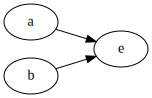

adding gt


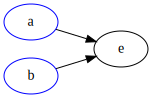

after message passing


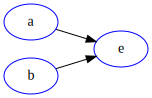

In [9]:
edge_indexes = [("a", "e"), ("b", "e")]
graph = BipartiteGraph(edge_indexes, nodes_type_a=["a", "b"], node_types=DimNode,
                       node_args={"dims": (3, )}, node_names=["a", "b", "e"])
pathways = PL([P(["a", "e"]), P(["b", "e"])])
assert graph.n_nodes_set == 0

print("init")
display(graph.to_graphviz(show_edge_name=False))

MB = 10
x = {"a": tr.randn(MB, 3), "b": tr.randn(MB, 3)}
graph.nodes_state = NodesState(graph.node_names, x)
assert graph.n_nodes_set == 2
print("adding gt")
display(graph.to_graphviz(show_edge_name=False))

models = nn.ModuleDict({"a->e": nn.Sequential(nn.Linear(3, 5), nn.Linear(5, 3)),
                        "b->e": nn.Sequential(nn.Linear(3, 5), nn.Linear(5, 3))})
mp = MyMessagePassing(graph, pathways, models=models)
y_graph = mp(x)
y = y_graph.readout()
assert y_graph.n_nodes_set == 3
assert len(y) == 3

print("after message passing")
display(y_graph.to_graphviz(show_edge_name=False))